In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pwd

/home/rene/Development/LLM/z/scratch-llm


In [3]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig, get_device


print(f"pytorch version: {torch.__version__}")

pytorch version: 2.1.0.post301


In [4]:
llm_config = LLMConfig(
    vocab_size=6_000, # 2_000
    context_size=256, # 64
    dim_emb=1024, # 256
    num_layers=8, # 4
    num_heads=8,
    emb_dropout=0.0,
    ffd_dim_hidden=4 * 512,
    ffd_bias=False,
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    device=get_device(),
    batch_size=64, # 64
    learning_rate=3e-4,
    weight_decay=1e-5,
    max_steps=3_000, # 4_000
    log_frequency=1,
)

In [5]:
input_file = "data/shakespeare/simonyi.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

In [6]:
tokenizer.sp.encode("test")

[6, 94, 42]

In [7]:
sentence = (
    "The role of the tokenizer is to build a mapping between a sentences represented as a string and token indices"
)
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁', 'ro', 'le', '▁of', '▁the', '▁t', 'o', 'k', 'en', 'iz', 'er', '▁', 'is', '▁t', 'o', '▁b', 'u', 'il', 'd', '▁a', '▁', 'ma', 'pp', 'ing', '▁be', 't', 'w', 'e', 'en', '▁a', '▁s', 'en', 'ten', 'c', 'es', '▁re', 'p', 'r', 'es', 'en', 'te', 'd', '▁a', 's', '▁a', '▁', 'st', 'ring', '▁', 'and', '▁t', 'o', 'k', 'en', '▁in', 'd', 'ic', 'es']


In [8]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

X, y = ds_train.get_batch(batch_size=1)

print(X.shape, y.shape)

torch.Size([1, 256]) torch.Size([1, 256])


In [9]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_hidden_dim=llm_config.ffd_dim_hidden,
    ffd_bias=llm_config.ffd_bias,
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"model size: {size:.3f}MB")

# print(model)

total params: 138,365,904
model size: 530.324MB


In [10]:
loss_history = train(
    model,
    ds_train,
    train_config.device,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Training on cuda.


/home/rene/miniconda3/envs/rapids-23.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacty of 23.69 GiB of which 36.75 MiB is free. Process 1756362 has 560.00 MiB memory in use. Including non-PyTorch memory, this process has 23.10 GiB memory in use. Of the allocated memory 22.78 GiB is allocated by PyTorch, and 20.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

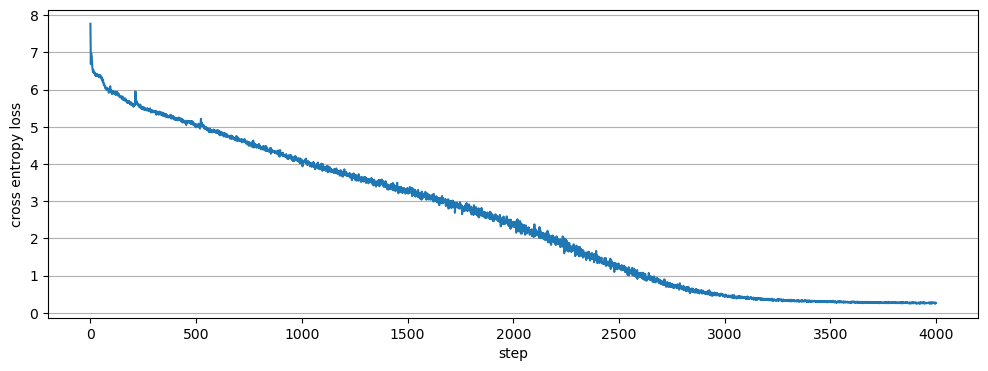

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

In [ ]:
# empty prompt to generate random stuff
prompt = torch.full((1, llm_config.context_size), tokenizer.pad_id, dtype=torch.int32).to(train_config.device)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'uer Herrmetrie, wie die Abnahme eines Roives mit der gleichen Methode übersachen, gegründeten die Werte an Zu'

In [ ]:
# generate from a prompt
prompt = (
    tokenizer.encode(
        "Schrödingers Gleichung beinhaltet ",
        beg_of_string=True,
        pad_seq=True,
        seq_len=llm_config.context_size,
    )
    .view(1, -1)
    .to(train_config.device)
)
out = model.generate(prompt, max_seq_len=30)
tokenizer.decode(out)

'Schrödingers Gleichung beinhaltet. Als bei einer herauskrümmung von rechtslich aufgestellten Weise sind die Zeitpunkte übereinstimmt, sie gar'

In [ ]:
out

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [ ]:
!ls -al data/shakespeare/ti*


-rw-rw-r-- 1 rene rene  269703 Mär 30 20:16 data/shakespeare/tinyshakespeare.model
-rw-rw-r-- 1 rene rene 1115393 Mär 30 20:16 data/shakespeare/tinyshakespeare.txt
-rw-rw-r-- 1 rene rene   33763 Mär 30 20:16 data/shakespeare/tinyshakespeare.vocab


In [ ]:
AT0010000000000000001000001713033

NameError: name 'AT0010000000000000001000001713033' is not defined